## Read the data

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
SEED = 888

In [3]:
df = pd.read_csv('Burget_Sales.csv')

In [4]:
df.sample(3)

,Date,burger_sales,Instagram_Cost,Bing_Cost,Facebook_Cost,Google_Cost,Pinterest_Cost,Tiktok Cost
471,2021-04-16,11310,1286.2,6306.2,2498.0,76162.39434,0.0,0.0
535,2021-06-19,5770,914.8,4660.0,10509.8,66379.53685,0.0,0.0
804,2022-03-29,9220,4294.0,0.0,19181.5,277294.23003,0.0,14418.3


In [3]:
date_col = 'Date'
target_col = 'burger_sales'
media_cols = df.columns.drop([date_col, target_col]).tolist()
media_cols

['Instagram_Cost',
 'Bing_Cost',
 'Facebook_Cost',
 'Google_Cost',
 'Pinterest_Cost',
 'Tiktok Cost']

In [4]:
# convert to datetime
df[date_col] = pd.to_datetime(df[date_col])

In [5]:
df.shape[0]

850

In [6]:
#Filter to the selected dates
date_format = "%m-%d-%Y"

start_date_str = '1-1-2021'
end_date_str = '5-1-2022'

start_date = datetime.strptime(start_date_str, date_format)
end_date = datetime.strptime(end_date_str, date_format)

df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy(deep=True)
len(df)

472

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 366 to 837
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            472 non-null    datetime64[ns]
 1   burger_sales    472 non-null    int64         
 2   Instagram_Cost  472 non-null    float64       
 3   Bing_Cost       472 non-null    float64       
 4   Facebook_Cost   472 non-null    float64       
 5   Google_Cost     472 non-null    float64       
 6   Pinterest_Cost  472 non-null    float64       
 7   Tiktok Cost     472 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 33.2 KB


## EDA 

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Date'>

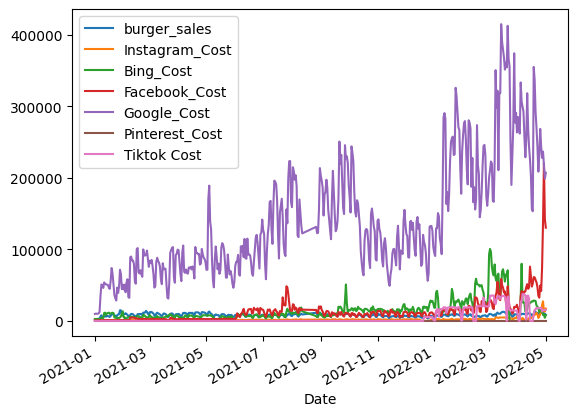

In [9]:
df.set_index(date_col).plot()

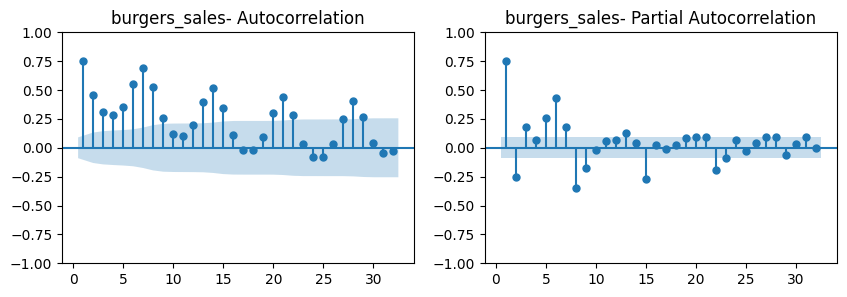

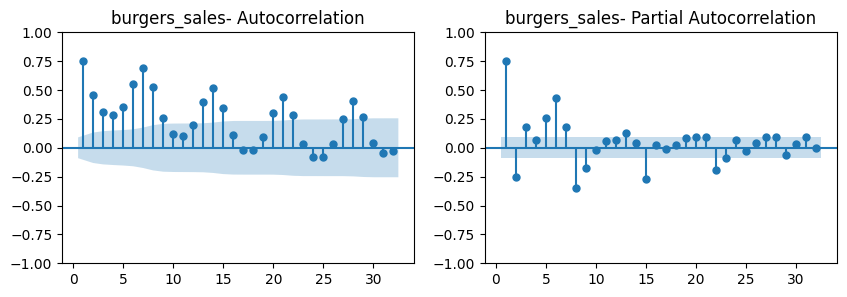

In [10]:
# understanding seasonality
fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_acf(df.burger_sales, lags=32, zero=False, title = f'burgers_sales- Autocorrelation', ax=ax[0])
plot_pacf(df.burger_sales, lags=32, zero=False, title = f'burgers_sales- Partial Autocorrelation', ax=ax[1])


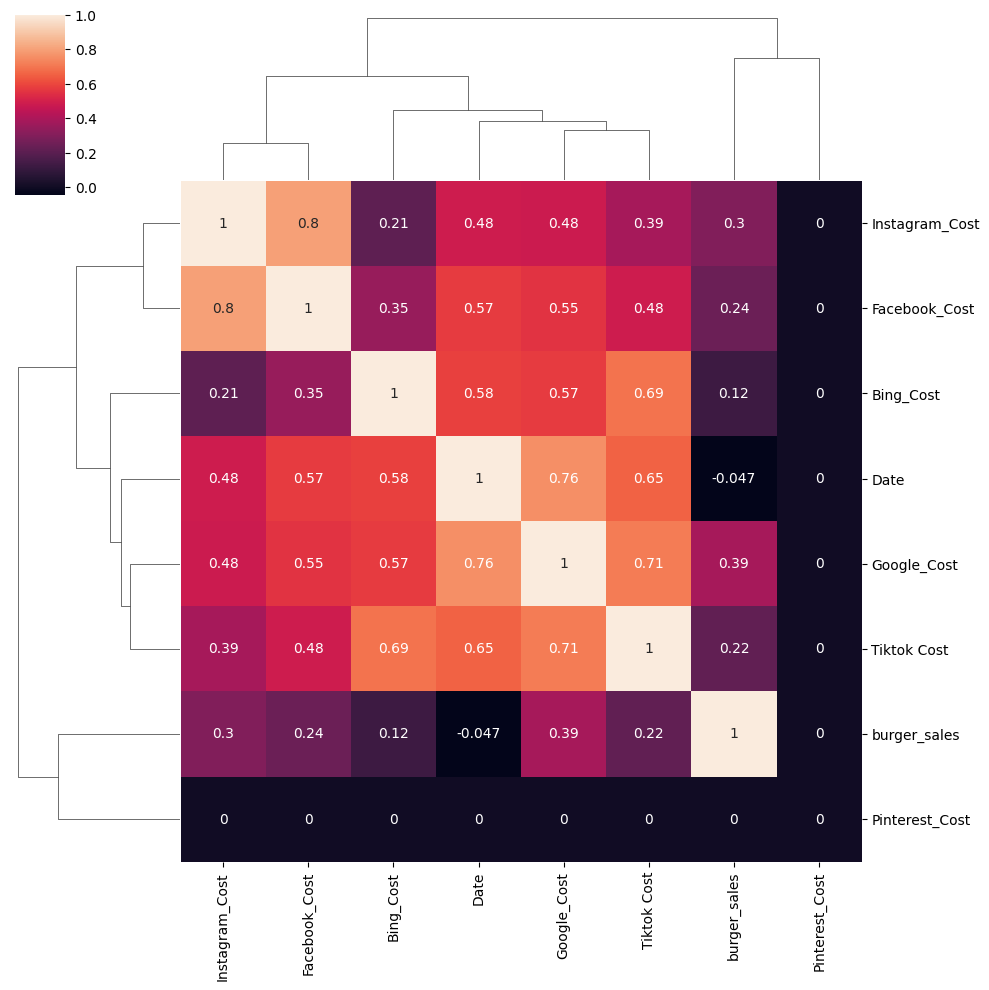

In [12]:
# Check for correlations
sns.clustermap(df.corr().fillna(0), annot=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 366 to 837
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            472 non-null    datetime64[ns]
 1   burger_sales    472 non-null    int64         
 2   Instagram_Cost  472 non-null    float64       
 3   Bing_Cost       472 non-null    float64       
 4   Facebook_Cost   472 non-null    float64       
 5   Google_Cost     472 non-null    float64       
 6   Pinterest_Cost  472 non-null    float64       
 7   Tiktok Cost     472 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 33.2 KB


In [15]:
df.describe()

,Date,burger_sales,Instagram_Cost,Bing_Cost,Facebook_Cost,Google_Cost,Pinterest_Cost,Tiktok Cost
count,472,472.000000,472.000000,472.000000,472.000000,472.000000,472.0,472.000000
mean,2021-08-31 20:32:32.542372864,8099.724576,2004.756992,14954.234958,13676.241800,140301.449155,0.0,4977.840254
min,2021-01-01 00:00:00,2010.000000,0.000000,0.000000,500.500000,9720.330910,0.0,0.000000
25%,2021-04-28 18:00:00,6547.500000,1187.525000,5710.675000,2608.600000,80150.218095,0.0,0.000000
50%,2021-09-07 12:00:00,8110.000000,1478.100000,9859.450000,10155.800000,118001.348510,0.0,0.000000
75%,2022-01-03 06:00:00,9472.500000,2045.250000,17009.450000,15664.000000,189407.773548,0.0,592.575000
max,2022-05-01 00:00:00,14880.000000,27365.800000,100594.500000,220378.100000,414996.447950,0.0,37641.900000
std,NaN,2137.158095,2258.353616,15479.299863,18691.215623,81733.482619,0.0,9777.069900


In [16]:
total_spend = np.sum([np.sum(df[col]) for col in media_cols])
total_spend

83031654.93081999

In [17]:
def get_media_stat(col):
    
    min_date = np.min(df[df[col] > 0][date_col])
    max_date = np.max(df[df[col] > 0][date_col])
    
    active_period_in_days = (max_date - min_date).days
    
    
    from_start_df = df[df[date_col] >= min_date]
    
    median = np.median(from_start_df[col]) if len(from_start_df) > 0 else 0.
    spent_sum = np.sum(from_start_df[col]) if len(from_start_df) > 0 else 0.
    
    spent_mean = np.mean(from_start_df[col]) if len(from_start_df) > 0 else 0.
    spent_percentile = np.percentile(from_start_df[col], 50) if len(from_start_df) > 0 else 0.
    spent_sum = np.sum(from_start_df[col]) if len(from_start_df) > 0 else 0.
    
    spent_percent = spent_sum/total_spend
    
    
    return (col, median, spent_sum , spent_mean, spent_percentile, df[df[col] > 0].shape[0], min_date, max_date, active_period_in_days, spent_percent)
    

In [18]:
rows = [get_media_stat(col) for col in media_cols]
pd.DataFrame(rows, columns = ["media", "median", "sum", "mean", "percetile_50", "days", "min_date", "max_date", "active_period_in_days", "spent_percent"]).sort_values(by = ["days"])

,media,median,sum,mean,percetile_50,days,min_date,max_date,active_period_in_days,spent_percent
4,Pinterest_Cost,0.00000,0.000000e+00,0.000000,0.00000,0,NaT,NaT,NaN,0.000000
5,Tiktok Cost,18792.50000,2.349541e+06,17799.550000,18792.50000,121,2021-12-21,2022-05-01,131.0,0.028297
1,Bing_Cost,9859.45000,7.058399e+06,14954.234958,9859.45000,460,2021-01-01,2022-05-01,485.0,0.085009
0,Instagram_Cost,1478.10000,9.462453e+05,2004.756992,1478.10000,462,2021-01-01,2022-05-01,485.0,0.011396
2,Facebook_Cost,10155.80000,6.455186e+06,13676.241800,10155.80000,472,2021-01-01,2022-05-01,485.0,0.077744
3,Google_Cost,118001.34851,6.622228e+07,140301.449155,118001.34851,472,2021-01-01,2022-05-01,485.0,0.797555


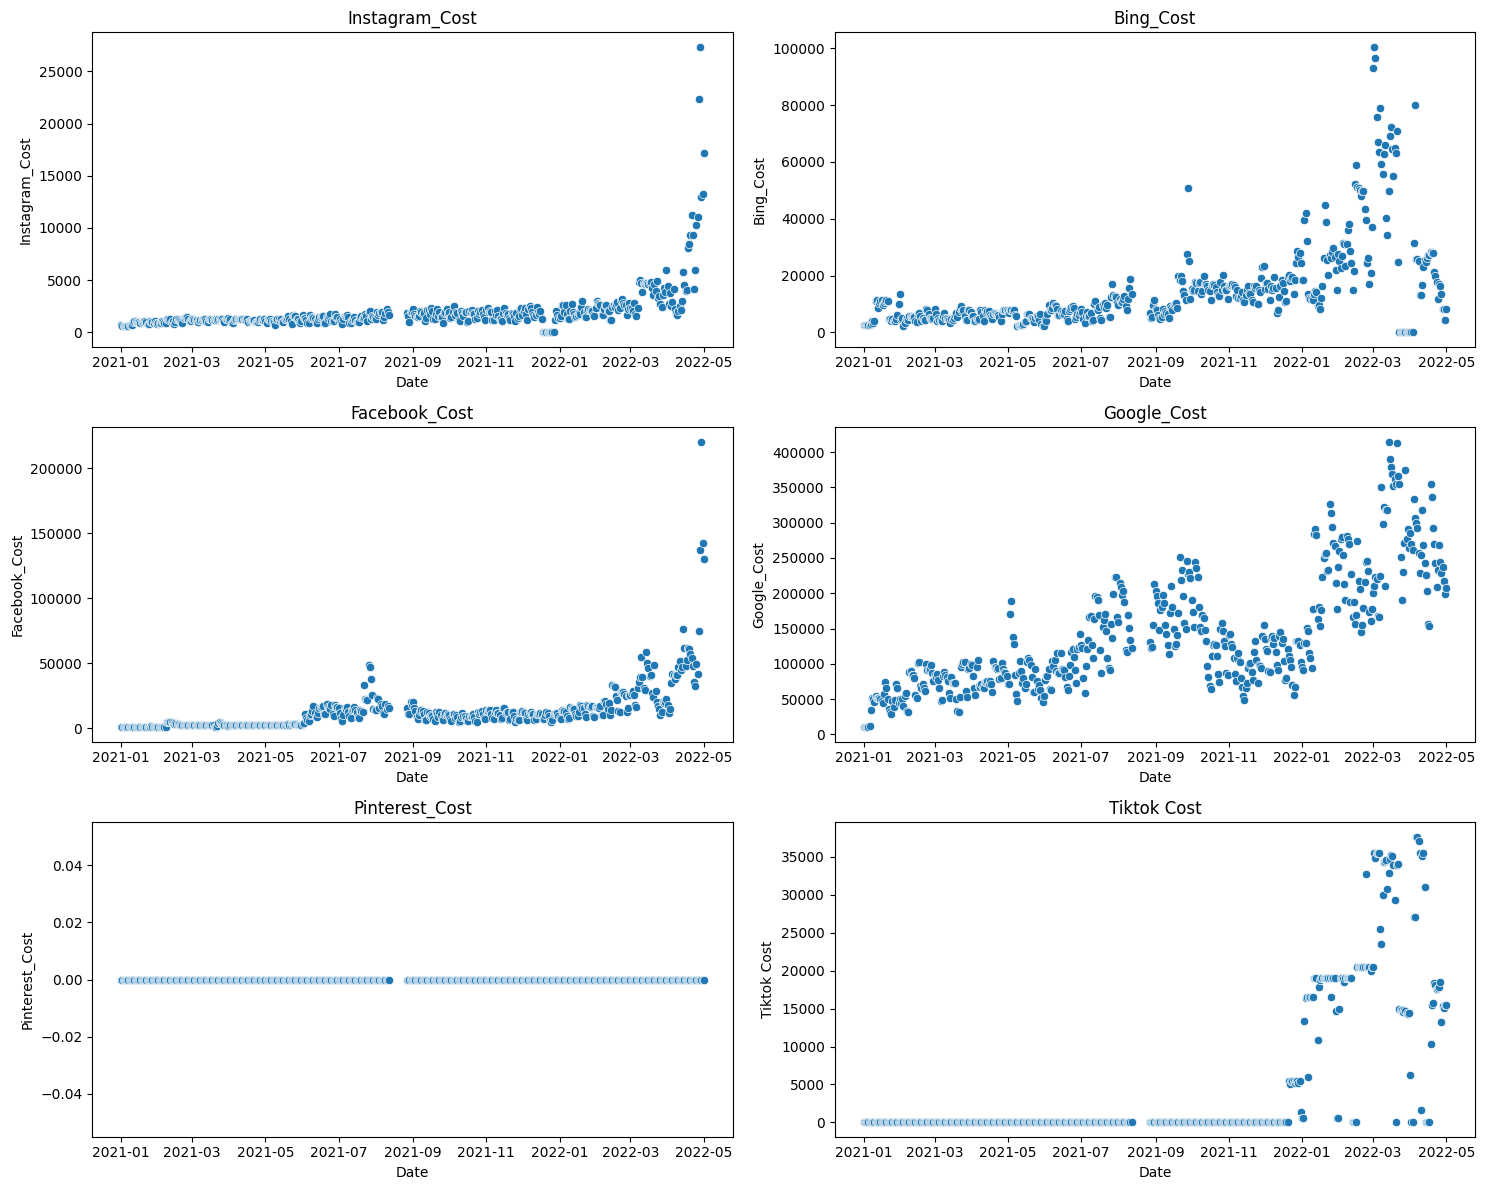

In [19]:

f, axes = plt.subplots(int(len(media_cols)/2), 2,  figsize=(15, 12))

axes =[x for xx in axes for x in xx]

for (i,col) in enumerate(media_cols):
    sns.scatterplot(data=df, x=date_col, y=col, ax = axes[i])    
    axes[i].title.set_text(col)
    
f.tight_layout()
plt.show()

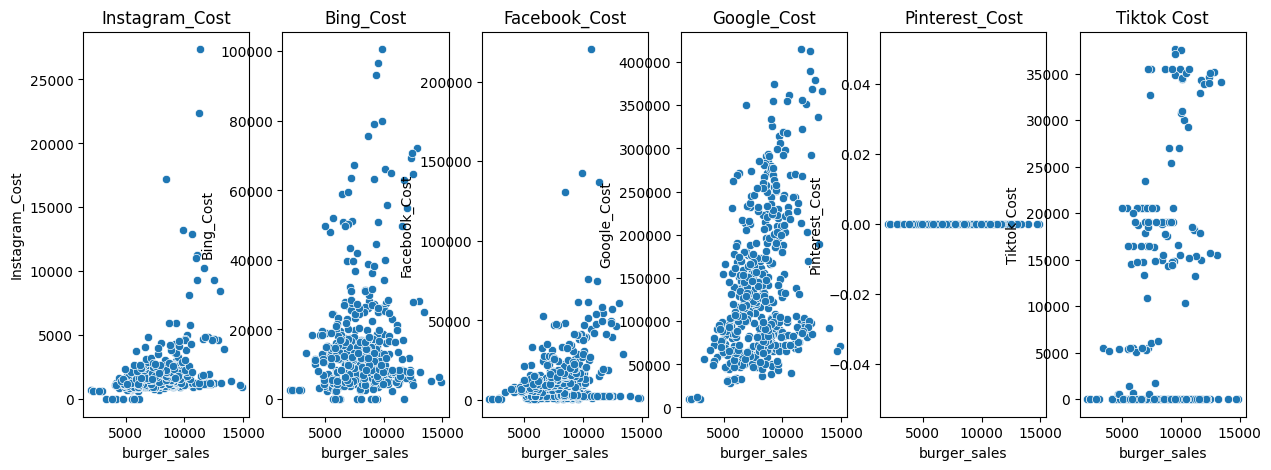

In [20]:
f, axes = plt.subplots(1, len(media_cols),  figsize=(15, 5))

for (i,col) in enumerate(media_cols):
    sns.scatterplot(data=df, x="burger_sales", y=col, ax=axes[i])
    axes[i].title.set_text(col)


In [21]:
df['dailt_media_spent'] = df[media_cols].sum(axis=1, numeric_only=True)


<Axes: xlabel='Date', ylabel='dailt_media_spent'>

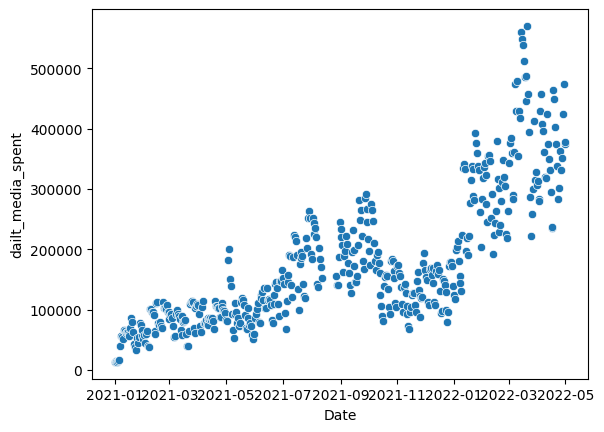

In [22]:
sns.scatterplot(data=df, x="Date", y="dailt_media_spent")

<Axes: xlabel='Date', ylabel='value'>

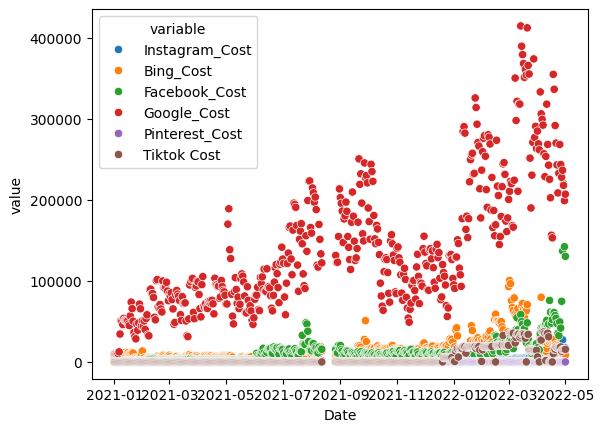

In [23]:
medias_daily_spent_df = df.melt(id_vars=['Date'], value_vars=media_cols)
sns.scatterplot(data=medias_daily_spent_df, x="Date", y="value", hue = "variable")

## Preprocess

In [24]:
reg_cols = [col for col in media_cols if np.sum(df[col]) > 0]
reg_cols

['Instagram_Cost', 'Bing_Cost', 'Facebook_Cost', 'Google_Cost', 'Tiktok Cost']

In [25]:
from sklearn.preprocessing import MaxAbsScaler

In [26]:
df_preped = df[[target_col, date_col] + reg_cols].copy(deep=True)

df_preped.rename(columns={target_col: 'y', date_col: 'ds'}, inplace=True)

# handle missing values
df_preped = df_preped.set_index('ds').asfreq('D').fillna(method='ffill').reset_index()

In [27]:
df_preped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              486 non-null    datetime64[ns]
 1   y               486 non-null    float64       
 2   Instagram_Cost  486 non-null    float64       
 3   Bing_Cost       486 non-null    float64       
 4   Facebook_Cost   486 non-null    float64       
 5   Google_Cost     486 non-null    float64       
 6   Tiktok Cost     486 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 26.7 KB


In [28]:
test_size=20
test_size

20

In [31]:
def pre_process(train_df, test_df, cols_to_scale, scale = True):
    if scale: 
        scaler = MaxAbsScaler() 
        scaler.fit(train_df[cols_to_scale])
        train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
        test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])
    
    return train_df, test_df, scaler

In [32]:

train_df = df_preped[:-test_size]
test_df = df_preped[-test_size:]

# scale the data
scale = True
train_df, test_df, scaler = pre_process(train_df, test_df, reg_cols, scale)


/var/folders/dd/9q4mm5nj79j0m66n9hqqtbzr0000gp/T/ipykernel_19146/428262424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
/var/folders/dd/9q4mm5nj79j0m66n9hqqtbzr0000gp/T/ipykernel_19146/428262424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])


# Forecast

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import models, utilities

/Users/gabi.burabia/anaconda3/envs/time_series/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Prophet / OLS


In [36]:
# Train a model
import prophet

model = prophet.Prophet()
for c in reg_cols:
    model.add_regressor(c)
model.fit(train_df)
preds = model.predict(test_df)
preds.head()

22:15:53 - cmdstanpy - INFO - Chain [1] start processing
22:15:53 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Bing_Cost,Bing_Cost_lower,Bing_Cost_upper,Facebook_Cost,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-04-12,4712.111721,6577.113642,9831.216643,4712.111721,4712.111721,78.947219,78.947219,78.947219,-661.953606,...,3067.886478,3067.886478,3067.886478,474.735142,474.735142,474.735142,0.0,0.0,0.0,8254.733341
1,2022-04-13,4697.019529,6450.000039,9647.674817,4697.019529,4697.019529,103.686463,103.686463,103.686463,-702.208959,...,2799.047373,2799.047373,2799.047373,582.500728,582.500728,582.500728,0.0,0.0,0.0,8078.567630
2,2022-04-14,4681.927337,5808.440733,8868.085624,4681.927337,4681.927337,96.544680,96.544680,96.544680,-1274.651688,...,1925.073661,1925.073661,1925.073661,758.414449,758.414449,758.414449,0.0,0.0,0.0,7365.415447
3,2022-04-15,4666.835145,4755.574899,7877.920677,4666.835145,4666.835145,109.457279,109.457279,109.457279,-989.758720,...,1322.171107,1322.171107,1322.171107,349.775787,349.775787,349.775787,0.0,0.0,0.0,6338.782039
4,2022-04-16,4651.742953,2900.018548,5946.211872,4651.571279,4652.011190,121.744778,121.744778,121.744778,-724.217055,...,530.653554,530.653554,530.653554,-801.014496,-801.014496,-801.014496,0.0,0.0,0.0,4381.382011


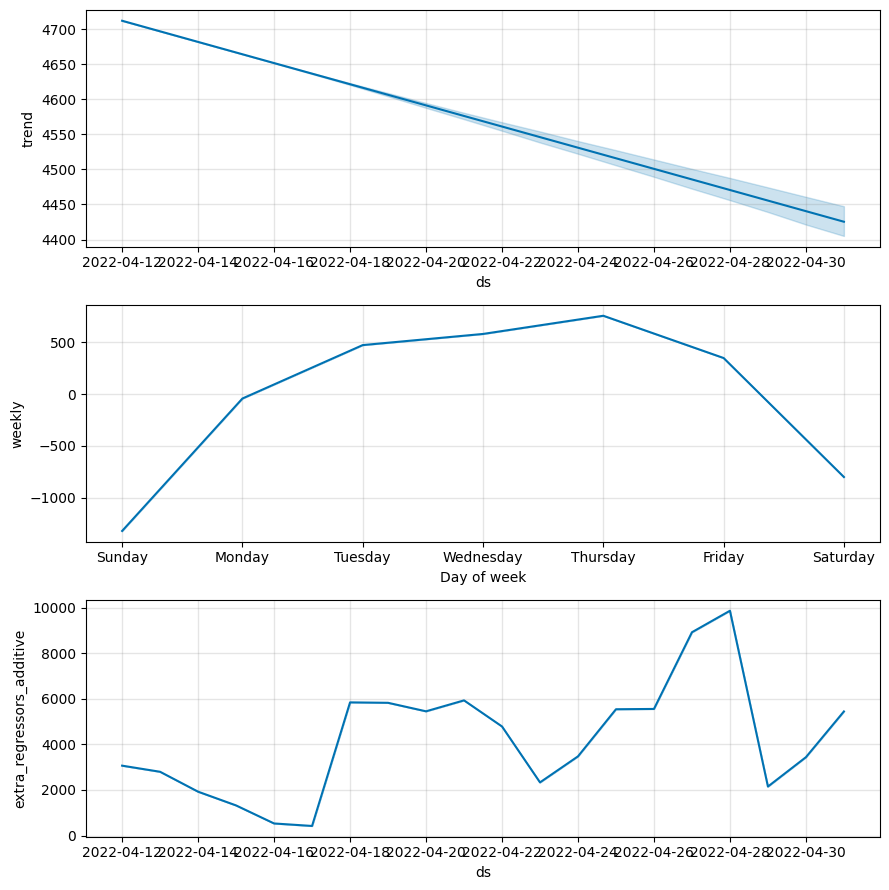

In [37]:
# plot components
model.plot_components(preds)
plt.show()

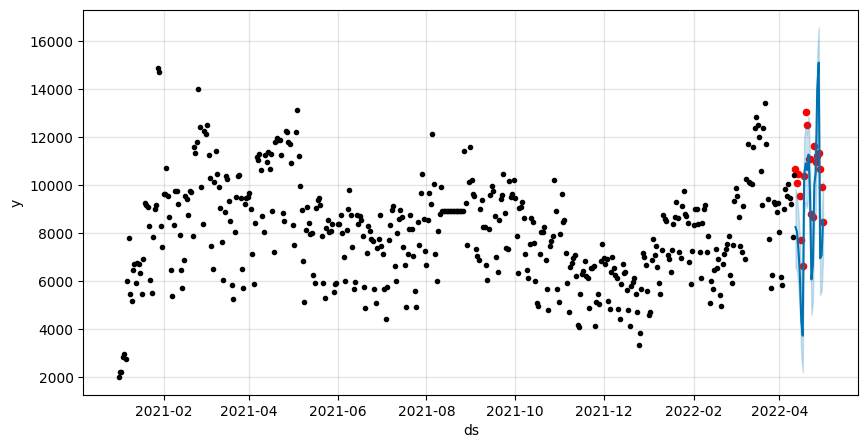

In [38]:
# plot predictions
fig, ax = plt.subplots(figsize=(10,5))
test_df.plot(kind='scatter', x='ds', y='y', ax=ax, color='red')
model.plot(preds, ax=ax)
plt.show()

In [39]:
# Get coefficients if the channels
prophet_coefs = utilities.regressor_coefficients(model)
prophet_coefs

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Instagram_Cost,additive,0.280019,2359.731025,2359.731025,2359.731025
1,Bing_Cost,additive,0.146355,971.894053,971.894053,971.894053
2,Facebook_Cost,additive,0.190549,-1152.788929,-1152.788929,-1152.788929
3,Google_Cost,additive,0.326515,7415.021977,7415.021977,7415.021977
4,Tiktok Cost,additive,0.117371,1326.105259,1326.105259,1326.105259


In [40]:
# Get priors (Hint: you might use it later (optional))
priors = prophet_coefs.set_index('regressor').coef.loc[reg_cols].tolist()
priors

[2359.7310251514336,
 971.8940533954994,
 -1152.7889287592634,
 7415.021977458841,
 1326.105259078399]

In [41]:
# Check performance
y_true = test_df.y
y_pred = preds.yhat
mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)

(5847707.156443069, 2122.2133131196993)

## Orbit

In [42]:
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT, LGT, KTR
from orbit.diagnostics.plot import plot_predicted_data

### DLT


In [43]:
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.models import DLT, LGT, KTR
from orbit.diagnostics.plot import plot_predicted_data

In [45]:
def build_predictions_dataset(dataset_df, predictions_df):
    
    dataset_y_df = dataset_df[["ds", "y"]]
    dataset_yhat_df = predictions_df[["ds", "prediction"]].rename(columns = {"prediction": "yhat"})

    dataset_y_yhat_df = pd.merge(dataset_y_df, dataset_yhat_df, on = ["ds"])
    
    return dataset_y_yhat_df


def train_dlt(response_col, date_col,  estimator, seed, seasonality, regressor_col, regressor_sign, damped_factor):


    dlt = DLT(
        response_col=response_col,
        date_col=date_col,
        estimator=estimator,
        seed=seed,
        seasonality=seasonality,
        regressor_sign=regressor_sign,
        regressor_col=regressor_col,
        verbose = False
    )

    dlt.fit(train_df)
    return dlt

In [46]:
dlt_model = train_dlt( response_col="y",
        date_col="ds",
        estimator='stan-mcmc',
        seed=SEED,
        seasonality=7, #52
        regressor_col=reg_cols,
        regressor_sign = ["+"]*len(reg_cols),  
        damped_factor = 0.1    
               )

chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 1 |                                                                | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 2 |█████████████████████████████████                                 | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


chain 4 |█████████████████████████████████                                 | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |█████████████████████████████████                                 | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
chain 2 |█████████████████████████████████████████████████▌                | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 2 |                 

In [47]:
train_dlt_predicted_df = dlt_model.predict(train_df, decompose=True)
test_dlt_predicted_df = dlt_model.predict(test_df, decompose=True)


dlt_train_y_yhat_df = build_predictions_dataset(train_df, train_dlt_predicted_df)
dlt_test_y_yhat_df = build_predictions_dataset(test_df, test_dlt_predicted_df)


dlt_test_y_yhat_df["dataset"] = "test"
dlt_train_y_yhat_df["dataset"] = "train"


dlt_datasets_y_yhat_df = pd.concat([dlt_test_y_yhat_df, dlt_train_y_yhat_df])



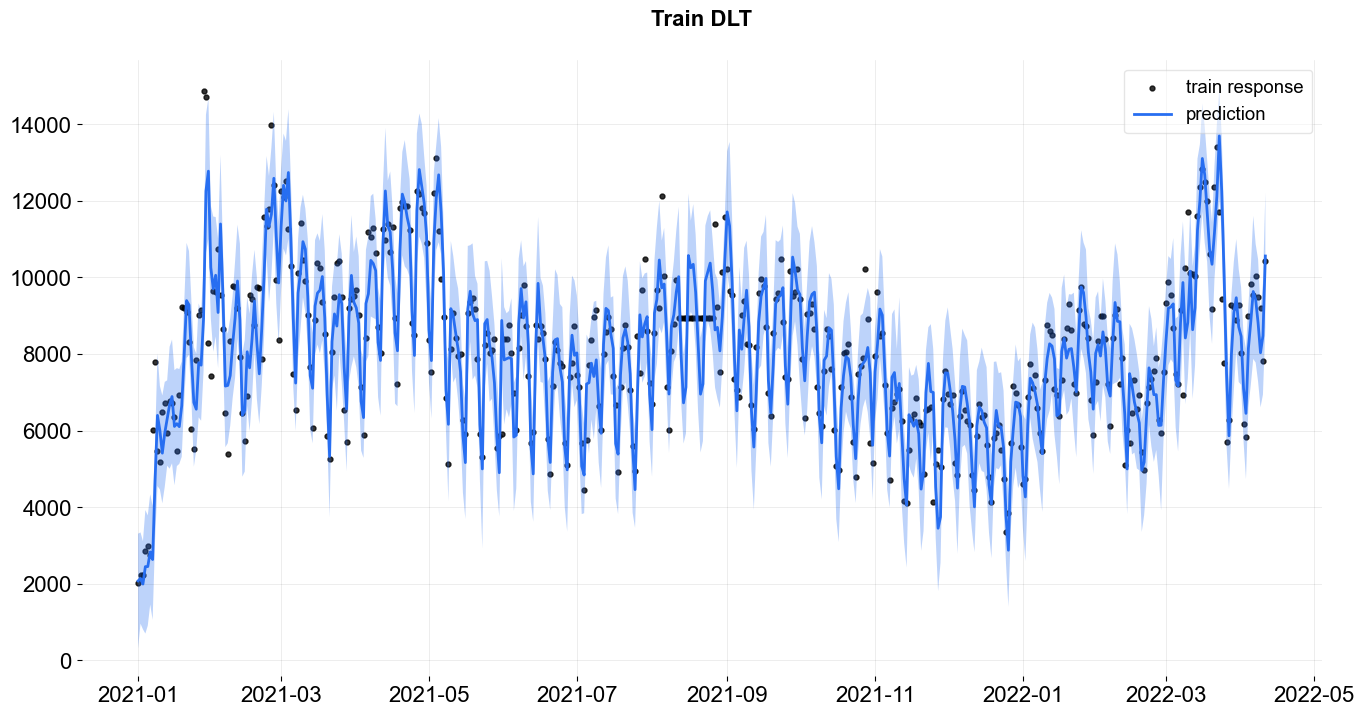

In [48]:
_ = plot_predicted_data(train_df, train_dlt_predicted_df, "ds", "y",  title='Train DLT')


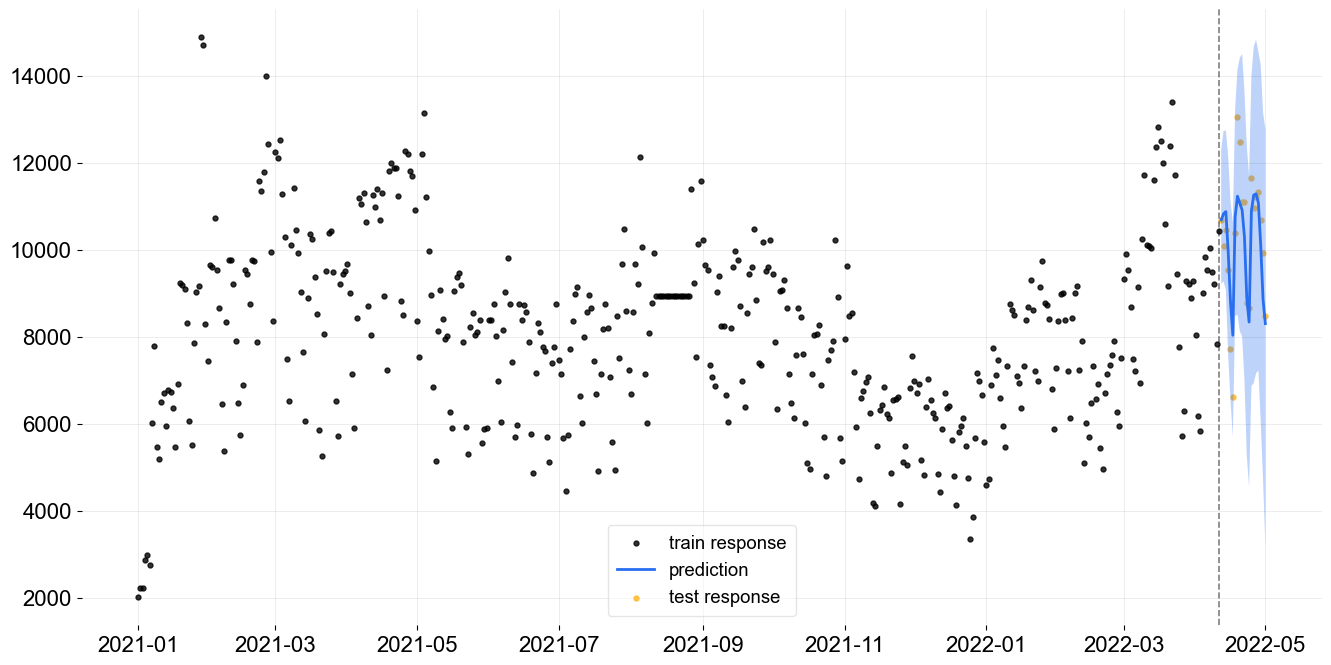

In [49]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=test_dlt_predicted_df,
                        date_col=dlt_model.date_col, actual_col=dlt_model.response_col,
                        test_actual_df=test_df)

<Axes: xlabel='y', ylabel='yhat'>

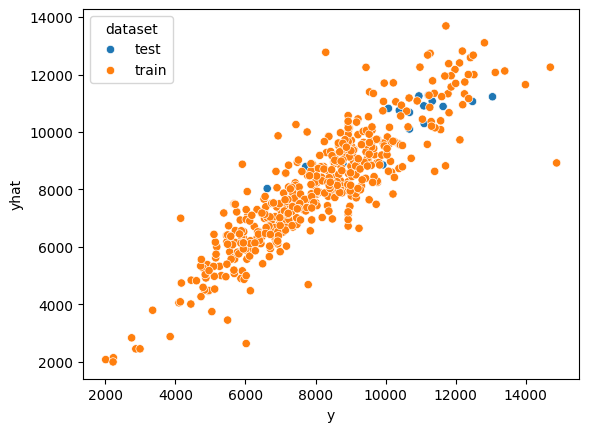

In [50]:
sns.scatterplot(data=dlt_datasets_y_yhat_df, x="y", y="yhat", hue = "dataset")   

Text(0.5, 1.0, 'Test')

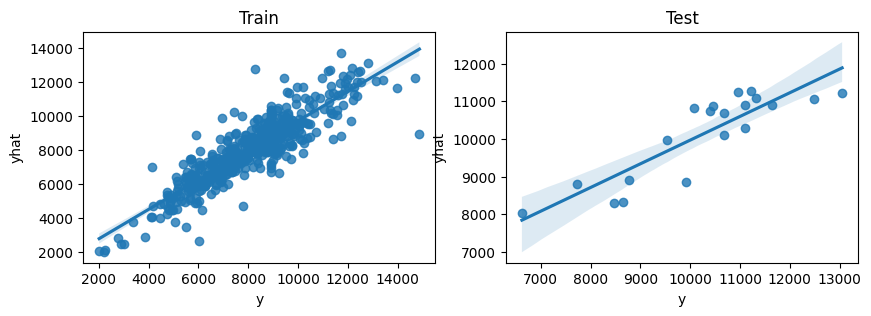

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,3))


sns.regplot(data=dlt_train_y_yhat_df, x="y", y="yhat", ax = ax[0])
ax[0].set_title("Train")
sns.regplot(data=dlt_test_y_yhat_df, x="y", y="yhat", ax = ax[1])
ax[1].set_title("Test")

In [56]:
dlt_model.get_regression_coefs().sort_values(by = ["coefficient"], ascending = False)

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
3,Google_Cost,Positive,0.727183,0.172411,2.029433,1.0,0.0
2,Facebook_Cost,Positive,0.692667,0.145685,1.678440,1.0,0.0
0,Instagram_Cost,Positive,0.658953,0.046886,1.806088,1.0,0.0
1,Bing_Cost,Positive,0.655671,0.088267,1.961903,1.0,0.0
4,Tiktok Cost,Positive,0.619240,0.035825,1.825048,1.0,0.0


In [57]:
f"MSE: Train: {mean_squared_error(dlt_train_y_yhat_df['y'], dlt_train_y_yhat_df['yhat'])} || Test: {mean_squared_error(dlt_test_y_yhat_df['y'], dlt_test_y_yhat_df['yhat'])}"

'MSE: Train: 979386.2585006928 || Test: 627328.228826816'

In [58]:
f"MAE: Train: {mean_absolute_error(dlt_train_y_yhat_df['y'], dlt_train_y_yhat_df['yhat'])} || Test: {mean_absolute_error(dlt_test_y_yhat_df['y'], dlt_test_y_yhat_df['yhat'])}"

'MAE: Train: 722.0220279286873 || Test: 614.7882688523189'

### KTR


In [59]:
def train_ktr(response_col, date_col, seed, regressor_col, estimator, num_steps, message, regressor_sign, train_df):
    
    ktr_model = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=seed,
    regressor_col=regressor_col,
    estimator=estimator,
    regressor_sign = regressor_sign, 
    num_steps=num_steps,
    message=message,
    )
    
    ktr_model.fit(train_df)
    
    return ktr_model
    
ktr_model = train_ktr(
    response_col="y",
    date_col="ds",
    seed=SEED,
    regressor_col=reg_cols,
    estimator='pyro-svi',
    # bootstrap sampling to capture uncertainties
    #n_bootstrap_draws=1e4,
    # pyro training config
    num_steps=301,
    message=100,
    regressor_sign = ["+"]*len(reg_cols),
    train_df = train_df
)


2023-12-04 22:16:23 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-12-04 22:16:23 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
/Users/gabi.burabia/anaconda3/envs/time_series/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
2023-12-04 22:16:23 - orbit - INFO - step    0 loss = 4267.4, scale = 0.094684
INFO:orbit:step    0 loss = 4267.4, scale = 0.094684
2023-12-04 22:16:24 - orbit - INFO - step  100 loss = 4232, scale = 0.22277
INFO:orbit:step  100 loss = 4232, scale = 0.22277
2023-12-04 22:16:24 - orbit - INFO - step  200 loss = 4231.4, scale = 0.23653
INFO:orbit:step  200 los

In [60]:
ktr_train_predicted_df = ktr_model.predict(df=train_df)
ktr_test_predicted_df = ktr_model.predict(df=test_df)

In [61]:
ktr_train_y_yhat_df = build_predictions_dataset(train_df, ktr_train_predicted_df)
ktr_test_y_yhat_df = build_predictions_dataset(test_df, ktr_test_predicted_df)


ktr_train_y_yhat_df["dataset"] = "train"
ktr_test_y_yhat_df["dataset"] = "test"

ktr_datasets_y_yhat_df = pd.concat([ktr_test_y_yhat_df, ktr_train_y_yhat_df])


<Axes: xlabel='y', ylabel='yhat'>

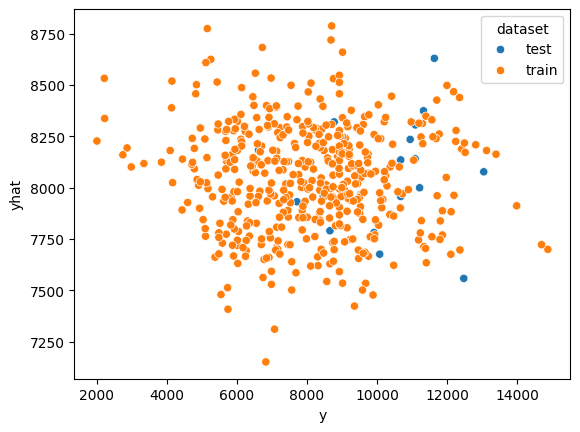

In [62]:
sns.scatterplot(data=ktr_datasets_y_yhat_df, x="y", y="yhat", hue = "dataset") 

Text(0.5, 1.0, 'Test')

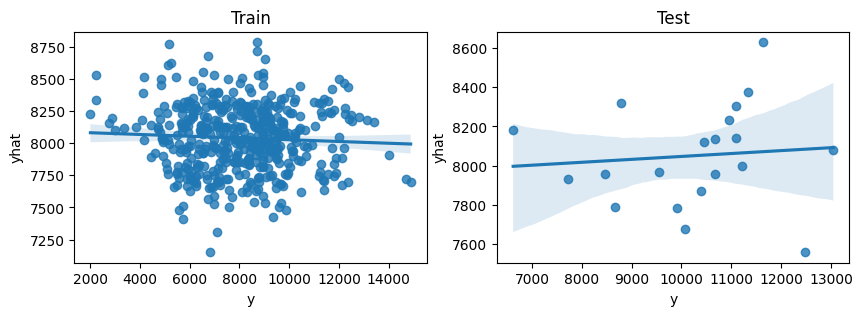

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10,3))


sns.regplot(data=ktr_train_y_yhat_df, x="y", y="yhat", ax = ax[0])
ax[0].set_title("Train")
sns.regplot(data=ktr_test_y_yhat_df, x="y", y="yhat", ax = ax[1])
ax[1].set_title("Test")

In [64]:
f"KTR MSE: Train: {mean_squared_error(ktr_train_y_yhat_df['y'], ktr_train_y_yhat_df['yhat'])} || Test: {mean_squared_error(ktr_test_y_yhat_df['y'], ktr_test_y_yhat_df['yhat'])}"


'KTR MSE: Train: 4458965.173193386 || Test: 7160732.7358355615'

In [65]:
f"KTR MAE: Train: {mean_absolute_error(ktr_train_y_yhat_df['y'], ktr_train_y_yhat_df['yhat'])} || Test: {mean_absolute_error(ktr_test_y_yhat_df['y'], ktr_test_y_yhat_df['yhat'])}"


'KTR MAE: Train: 1675.2016976815398 || Test: 2369.413697770323'

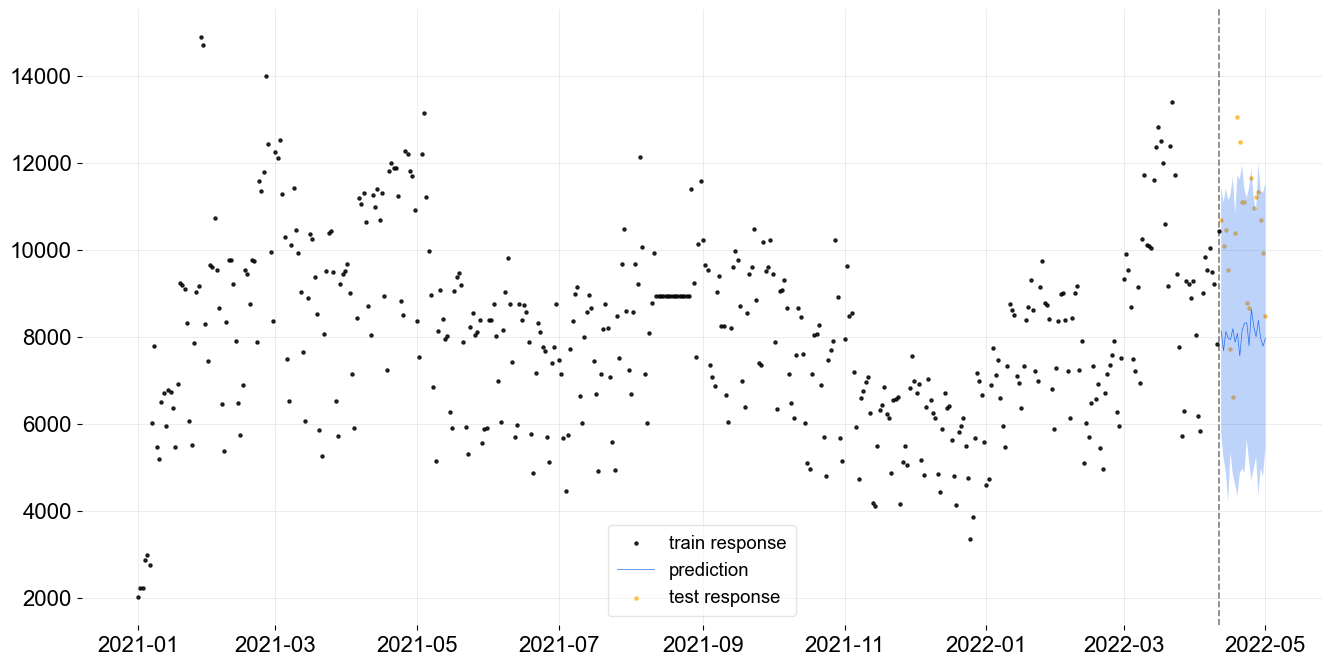

In [66]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=ktr_test_predicted_df,
                        date_col="ds", actual_col="y",
                        test_actual_df=test_df, markersize=20, lw=.5)

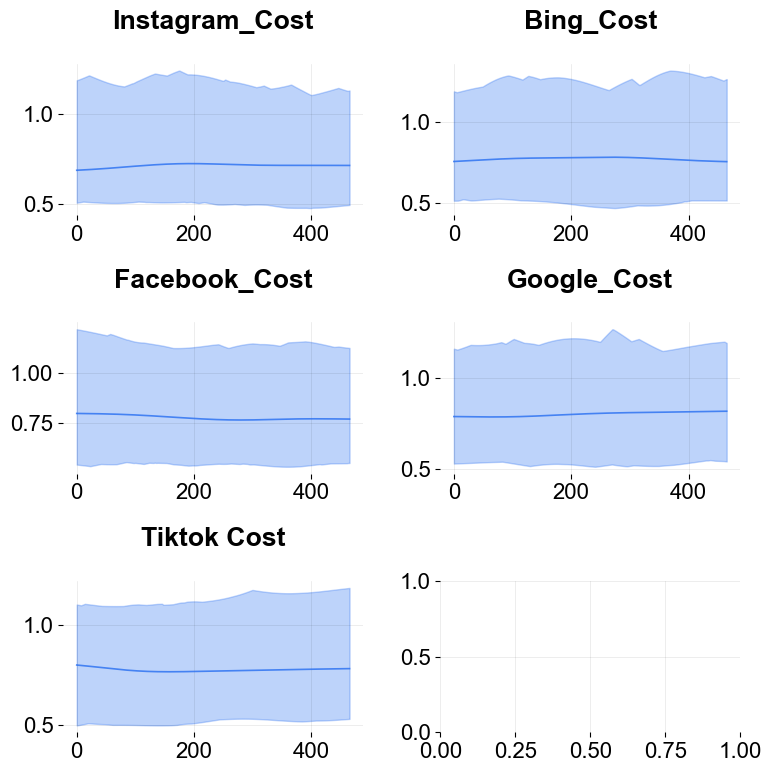

array([[<Axes: title={'center': 'Instagram_Cost'}>,
        <Axes: title={'center': 'Bing_Cost'}>],
       [<Axes: title={'center': 'Facebook_Cost'}>,
        <Axes: title={'center': 'Google_Cost'}>],
       [<Axes: title={'center': 'Tiktok Cost'}>, <Axes: >]], dtype=object)

In [67]:
ktr_model.plot_regression_coefs(figsize=(8, 8), include_ci=True)

In [69]:
def calc_metrics(regression_coefs, df, reg_cols):
    contribution = scaler.inverse_transform(regression_coefs * df[reg_cols])
    contribution = pd.DataFrame(contribution,columns=reg_cols).sum(axis=0)
    #contribution.plot(kind='bar')
    
    costs_raw = df[reg_cols].sum(axis=0)
    cost_contribution_df = pd.concat([costs_raw, contribution], axis=1).reset_index().rename(columns = {0: "cost", 1: "contribution", "index":"media"})
    cost_contribution_df["roi"] = cost_contribution_df["contribution"]/cost_contribution_df["cost"]
    return cost_contribution_df
    

In [70]:
ktr_metrics_df = calc_metrics(ktr_model.get_regression_coefs().iloc[:, 1:], df, reg_cols)


Text(0.5, 1.0, 'KTR Contribution')

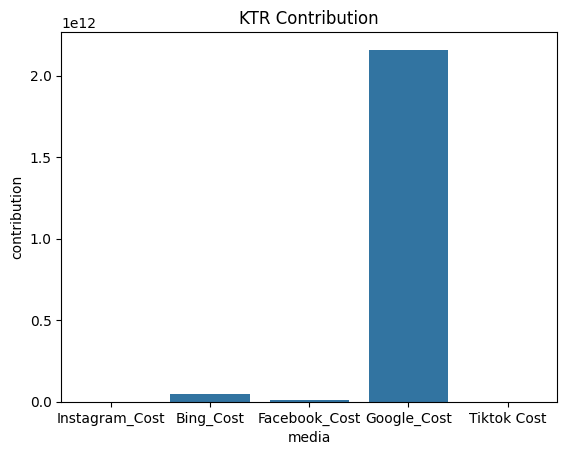

In [71]:
sns.barplot(ktr_metrics_df, x="media", y="contribution").set_title('KTR Contribution')


Text(0.5, 1.0, 'KTR ROI')

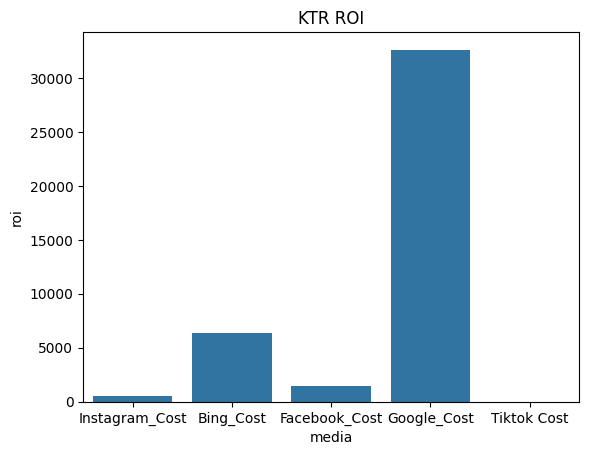

In [72]:
sns.barplot(ktr_metrics_df, x="media", y="roi").set_title('KTR ROI')


In [73]:
dlt_regression_coefs = dlt_model.get_regression_coefs()[["regressor", "coefficient"]]

coefs = {}
for (_, row) in dlt_regression_coefs.iterrows():
    coefs[row["regressor"]] = row['coefficient']
    
dlt_regression_coefs_df = pd.DataFrame([coefs] * len(train_df))

dlt_metrics_df = calc_metrics(dlt_regression_coefs_df, df, reg_cols)



Text(0.5, 1.0, 'DLT Contribution')

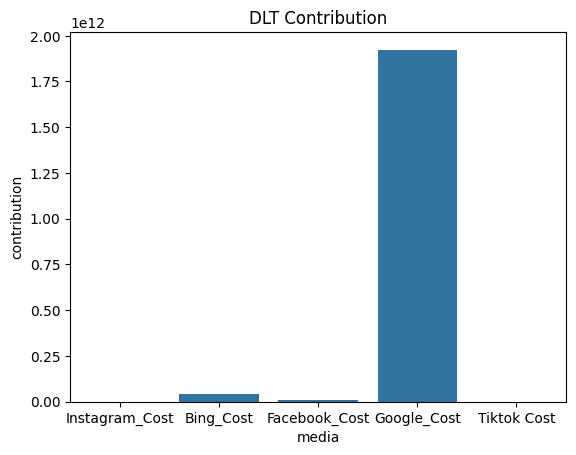

In [74]:
sns.barplot(dlt_metrics_df, x="media", y="contribution").set_title('DLT Contribution')


Text(0.5, 1.0, 'DLT ROI')

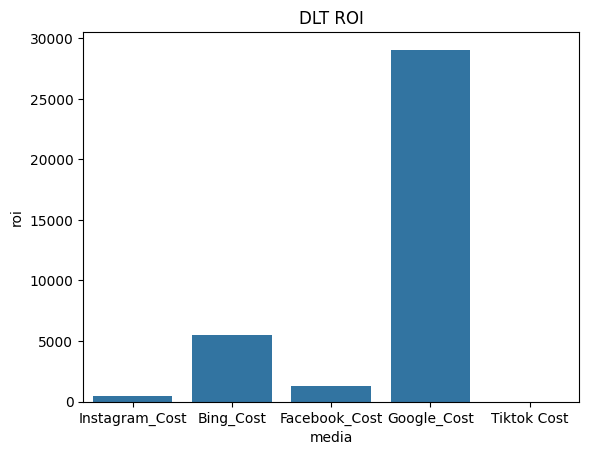

In [75]:
sns.barplot(dlt_metrics_df, x="media", y="roi").set_title('DLT ROI')
